# Import

In [25]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import heapq
from collections import deque

# Generátor bludiště s místnostmi

In [26]:

# room size ... jak velke ctverce budou tvorit mistnosti
# room density ... kolik procent budou tvorit mistnosti
def generate_maze_with_rooms(aX_size, aY_size, room_density=0.05, room_size=3): 
    aWalls = [[[1,1,1,1] for _ in range(aX_size)] for _ in range(aY_size)] #indexy sten: (leva, horni, prava, dolni)
    aVisited_nodes = [[False for _ in range(aX_size)] for _ in range(aY_size)]
    path = [(0,0)]
    aVisited_nodes[0][0] = True

    #1. základní perfect maze (rekurzivní backtracking)
    while path:
        x, y = path[-1] #nacti posledni prvek z listu
        possible_directions = []    #list: (leva, prava, index nasi steny, index sousedni steny)
        if x > 0 and not aVisited_nodes[y][x-1]:    #jde jit doleva?
            possible_directions.append((-1, 0, 0, 2))
        if x < aX_size-1 and not aVisited_nodes[y][x+1]:    #jde jit doprava?
            possible_directions.append((1, 0, 2, 0))
        if y > 0 and not aVisited_nodes[y-1][x]:    #jde jit dolu?
            possible_directions.append((0, -1, 1, 3))   
        if y < aY_size-1 and not aVisited_nodes[y+1][x]:    #jde jit nahoru?
            possible_directions.append((0, 1, 3, 1))    

        if possible_directions: #v pripade, za mam kam jit
            dx, dy, w1, w2 = random.choice(possible_directions) #rozhodnout se, kam se rozejdu
            nx, ny = x+dx, y+dy
            aWalls[y][x][w1] = 0
            aWalls[ny][nx][w2] = 0
            aVisited_nodes[ny][nx] = True
            path.append((nx, ny))
        else:   #pokud nemam kam jit
            path.pop()

    #2. část - přidávám tzv. cykly - smyčky, které se dají projít dokola
    for y in range(aY_size):
        for x in range(aX_size):
            for i, (dy, dx) in enumerate([(0,-1), (-1,0), (0,1), (1,0)]):
                if random.random() < 0.03:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < aY_size and 0 <= nx < aX_size:
                        aWalls[y][x][i] = 0
                        aWalls[ny][nx][(i+2)%4] = 0

    # 3. část - čistím celé bloky
    num_rooms = int(aX_size * aY_size * room_density)
    for _ in range(num_rooms):
        rx = random.randint(1, aX_size - room_size - 1)
        ry = random.randint(1, aY_size - room_size - 1)
        for y in range(ry, ry + room_size):
            for x in range(rx, rx + room_size):
                if y < aY_size and x < aX_size:
                    aWalls[y][x] = [0,0,0,0]

    return aWalls

# Algoritmy pro prohledávání bludiště

## BFS

In [27]:
def maze_bfs_search(aWalls, aStart, aGoal):
    aY_size = len(aWalls)
    aX_size = len(aWalls[0])
    aNodes_visited = [[False for _ in range(aX_size)] for _ in range(aY_size)]
    aParents = {}
    aQueue = deque([aStart])
    aNodes_visited[aStart[0]][aStart[1]] = True

    direction_vectors = [
        (-1, 0, 0),   # left
        (1, 0, 2),   # right
        (0, -1, 1),  # up
        (0, 1, 3)    # down
    ]

    while aQueue:
        aY, aX = aQueue.popleft()
        if (aY, aX) == aGoal:
            aPath = []
            while (aY, aX) != aStart:
                aPath.append((aY, aX))
                aY, aX = aParents[(aY, aX)]
            aPath.append(aStart)
            return aPath[::-1], aNodes_visited

        for dx, dy, wall_index in direction_vectors:
            newX, newY = aX + dx, aY + dy
            if 0 <= newY < aY_size and 0 <= newX < aX_size:
                if aWalls[aY][aX][wall_index] == 0 and not aNodes_visited[newY][newX]:
                    aNodes_visited[newY][newX] = True
                    aParents[(newY, newX)] = (aY, aX)
                    aQueue.append((newY, newX))

    return None, aNodes_visited

## DFS

In [28]:
def maze_dfs_search(aWalls, aStart, aGoal):
    aY_size = len(aWalls)
    aX_size = len(aWalls[0])
    aNodes_visited = [[False for _ in range(aX_size)] for _ in range(aY_size)]
    aParents = {}
    stack = [aStart]
    aNodes_visited[aStart[0]][aStart[1]] = True

    direction_vectors = [
        (-1, 0, 0),  # left
        (1, 0, 2),   # right
        (0, -1, 1),  # up
        (0, 1, 3)    # down
    ]

    while stack:
        aY, aX = stack.pop()
        if (aY, aX) == aGoal:
            aPath = []
            while (aY, aX) != aStart:
                aPath.append((aY, aX))
                aY, aX = aParents[(aY, aX)]
            aPath.append(aStart)
            return aPath[::-1], aNodes_visited #aPath[::-1] .. rekonstrukce cesty

        for dx, dy, wall_index in direction_vectors:
            newX, newY = aX + dx, aY + dy
            if 0 <= newY < aY_size and 0 <= newX < aX_size:
                if aWalls[aY][aX][wall_index] == 0 and not aNodes_visited[newY][newX]:
                    aNodes_visited[newY][newX] = True
                    aParents[(newY, newX)] = (aY, aX)
                    stack.append((newY, newX))

    return None, aNodes_visited

## A*

In [29]:
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def maze_astar_search(aWalls, aStart, aGoal):
    aY_size = len(aWalls)
    aX_size = len(aWalls[0])
    open_set = []
    heapq.heappush(open_set, (0, aStart))
    came_from = {}
    g_score = {aStart: 0}
    aNodes_visited = [[False for _ in range(aX_size)] for _ in range(aY_size)]

    direction_vectors = [
        (-1, 0, 0),
        (1, 0, 2),
        (0, -1, 1),
        (0, 1, 3)
    ]

    while open_set:
        _, current = heapq.heappop(open_set)
        aY, aX = current
        aNodes_visited[aY][aX] = True

        if current == aGoal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]    #podivej se, odkud jsi prisel
            path.append(aStart)
            return path[::-1], aNodes_visited

        for dx, dy, wall_index in direction_vectors:
            newX, newY = aX + dx, aY + dy
            if 0 <= newY < aY_size and 0 <= newX < aX_size:
                if aWalls[aY][aX][wall_index] == 0:
                    tentative_g = g_score[current] + 1
                    neighbor = (newY, newX)
                    if tentative_g < g_score.get(neighbor, float('inf')):
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g
                        f_score = tentative_g + heuristic(neighbor, aGoal)
                        heapq.heappush(open_set, (f_score, neighbor))

    return None, aNodes_visited

# Kreslení bludiště včetně vlastní cesty

In [30]:

def draw_maze(aWalls):
    fig, axes = plt.subplots(1, 4, figsize=(30, 10))
    aX_size = len(aWalls[0])
    aY_size = len(aWalls)
    for ax in axes:
        for y in range(aY_size):
            for x in range(aX_size):
                left, top, right, bottom = aWalls[y][x]
                x0, x1 = x, x+1
                y0, y1 = aY_size - y, aY_size - (y+1)
                if top: ax.plot([x0, x1], [y0, y0], color="black")
                if right: ax.plot([x1, x1], [y0, y1], color="black")
                if bottom: ax.plot([x0, x1], [y1, y1], color="black")
                if left: ax.plot([x0, x0], [y0, y1], color="black")
        ax.set_aspect("equal")
        ax.axis("off")
    axes[0].set_title("Empty Maze")
    axes[1].set_title("DFS")
    axes[2].set_title("BFS")
    axes[3].set_title("A* (Manhattan)")
    return fig, axes

def draw_path(aAxes, aNodes_visited, aPath, idx, color_visited, color_path):
    aY_size = len(aNodes_visited)
    y_coords, x_coords = np.where(aNodes_visited)
    aAxes[idx].scatter(x_coords + 0.5, aY_size - (y_coords + 0.5), color=color_visited, s=6, label="Visited")
    for (y, x) in aPath:
        aAxes[idx].scatter(x + 0.5, aY_size - (y + 0.5), color=color_path, s=10)
    aAxes[idx].legend()


# Funkce main

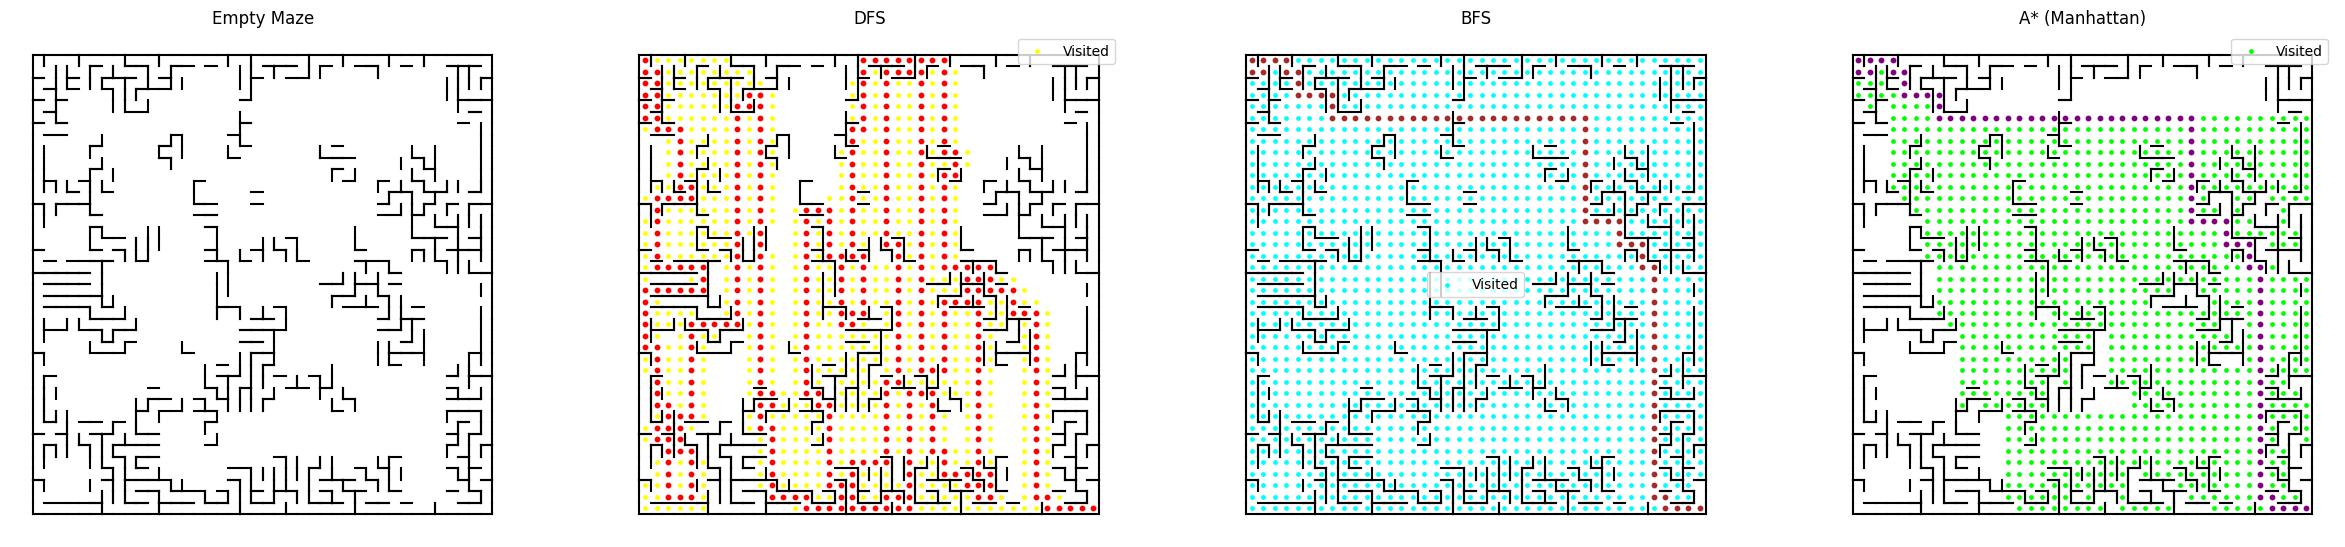


Výsledky hledání:
Algoritmus | Délka cesty  | Navštíveno   | Čas [s] 
-------------------------------------------------------
BFS        | 81           | 1598         | 0.00104
DFS        | 421          | 1050         | 0.00059
A*         | 81           | 1052         | 0.00163


In [31]:

def main():
    walls = generate_maze_with_rooms(40, 40, room_density=0.06, room_size=4)
    fig, axes = draw_maze(walls)
    start, goal = (0, 0), (39, 39)

    # mereni BFS ---
    t0 = time.time()
    bfs_path, bfs_visited = maze_bfs_search(walls, start, goal)
    bfs_time = time.time() - t0
    draw_path(axes, bfs_visited, bfs_path, 2, "cyan", "brown")

    # mereni DFS ---
    t0 = time.time()
    dfs_path, dfs_visited = maze_dfs_search(walls, start, goal)
    dfs_time = time.time() - t0
    draw_path(axes, dfs_visited, dfs_path, 1, "yellow", "red")

    # mereni A* ---
    t0 = time.time()
    a_path, a_visited = maze_astar_search(walls, start, goal)
    a_time = time.time() - t0
    draw_path(axes, a_visited, a_path, 3, "lime", "purple")

    plt.show()

    # Výpis výsledků
    print("\nVýsledky hledání:")
    print(f"{'Algoritmus':<10} | {'Délka cesty':<12} | {'Navštíveno':<12} | {'Čas [s]':<8}")
    print("-" * 55)
    print(f"{'BFS':<10} | {len(bfs_path):<12} | {np.sum(bfs_visited):<12} | {bfs_time:.5f}")
    print(f"{'DFS':<10} | {len(dfs_path):<12} | {np.sum(dfs_visited):<12} | {dfs_time:.5f}")
    print(f"{'A*':<10} | {len(a_path):<12} | {np.sum(a_visited):<12} | {a_time:.5f}")

if __name__ == "__main__":
    main()